In [1]:
from modules.models import travelKawaharaPINN, create_dense_model
from modules.data import simulate_travel_kawahara
from modules.plots import plot_KdV_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


2023-05-24 10:35:28.363425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-05-24 10:35:47.250054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


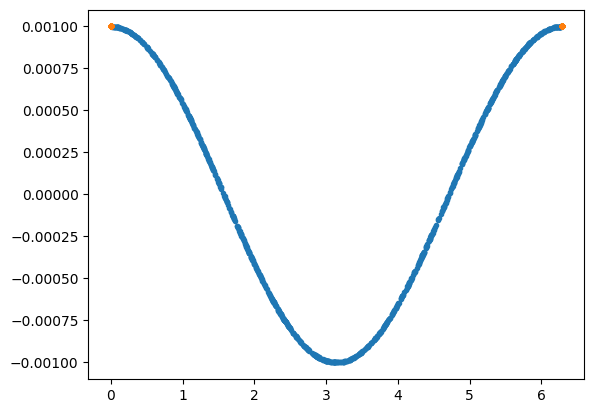

In [2]:
x_start = 0
length = 2*np.pi
time = np.pi / 2


(tx_eqn, y_eqn, u_exact), (tx_init, y_init), (tx_boundary, y_boundary),solution = \
    simulate_travel_kawahara(1000, x_start, length , time , random_seed = 42, dtype=tf.float32) 

21
[ -6.90775528          nan -23.61363801          nan -42.57431513]
4.9554893444985375e-89
[False False False False False False False False False False False False
 False False False False False False False False False False False]


/var/folders/8f/ms98g78j5vz0vnknq4rmjbwm0000gn/T/ipykernel_3065/3907077494.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(solution[2::])[0:5])


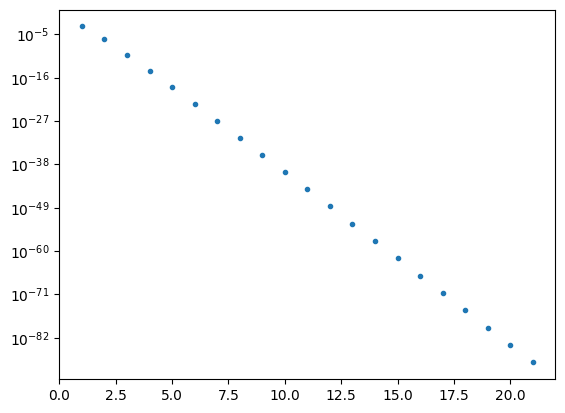

In [3]:
n = np.arange(1,22,1)
print(len(solution[2::]))
plt.semilogy(n,np.abs(solution[2::]),'.')
print(np.log(solution[2::])[0:5])
print(solution[-1])
print(np.isnan(solution))

In [4]:
dudt = tf.zeros_like(y_boundary)
inputs = [tx_eqn, tx_init, tx_boundary]
outputs = [u_exact, y_eqn, y_init, y_boundary, dudt]

In [22]:
backbone = create_dense_model([150], activation=tf.math.cos, initializer='glorot_normal', \
    n_inputs=2, n_outputs=1)

In [23]:
solution[0]

0.7500009999995948

In [24]:
pinn = travelKawaharaPINN(backbone, c=solution[0], alpha = 1.0, beta= 1/4 ,sigma = 1.0)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.92)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
pinn.compile(optimizer=optimizer)

In [25]:
history = pinn.fit_custom(inputs, outputs, epochs=20000, print_every=1000)

Epoch 0, Loss Residual: 0.0347, Loss Initial: 2.7510, Loss Boundary: 2.5876, MAE: 1.6247
Epoch 1000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0064
Epoch 2000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0033
Epoch 3000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0021
Epoch 4000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0013
Epoch 5000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0009
Epoch 6000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0007
Epoch 7000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0007
Epoch 8000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0007
Epoch 9000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0007
Epoch 10000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MA

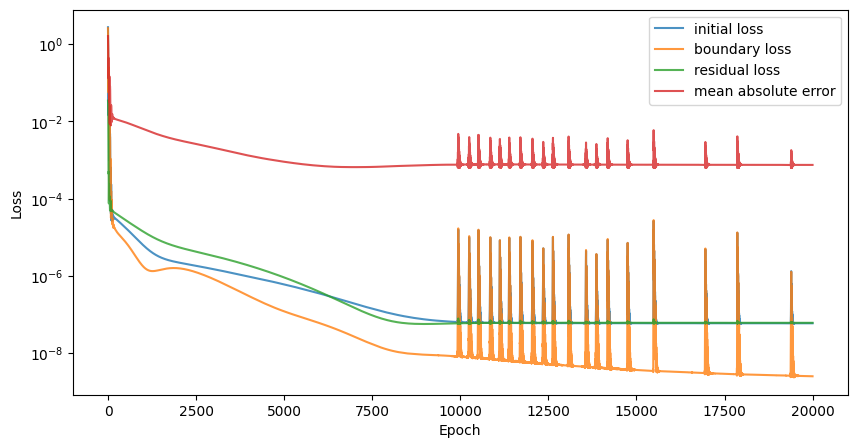

In [26]:
plot_training_loss(history, y_scale='log')

1/1 [==============================] - 0s 29ms/step


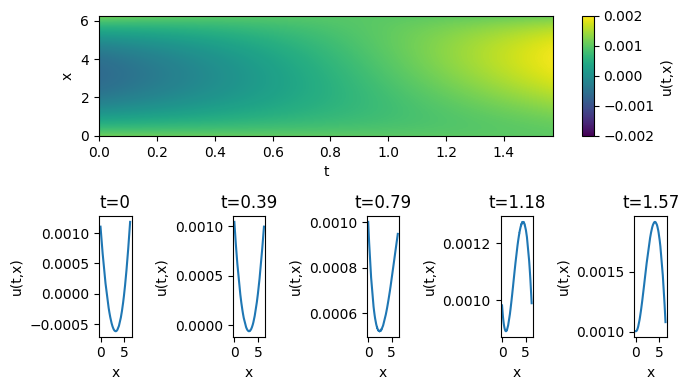

In [27]:
plot_KdV_model(pinn.backbone, x_start,length, time, -0.002,0.002, save_path = None, show=True) 

In [20]:
def plot_snapshots(timeList,num_test_samples = 1000):
    x_flat = np.linspace(x_start, length, num_test_samples)
    t_flat = np.linspace(0, time, num_test_samples)
    t_cross_sections = timeList
    for i, t_cs in enumerate(t_cross_sections):
        tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
        u = pinn.backbone.predict(tx, batch_size=num_test_samples)
        plt.plot(x_flat, u, label = 'prediction')
        plt.title('t={}'.format(np.round(t_cs,2)))
        plt.xlabel('x')
        plt.ylabel('u(t,x)')
    plt.plot(tx_eqn[:,1:], u_exact, '.',label = 'exact')
    plt.legend()
    return

1/1 [==============================] - 0s 33ms/step


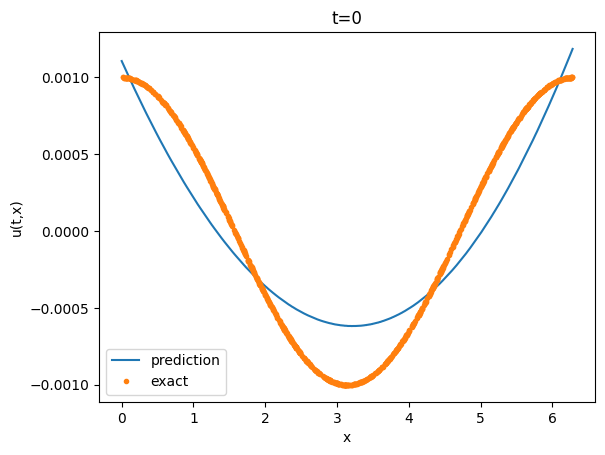

In [28]:
plot_snapshots([0])

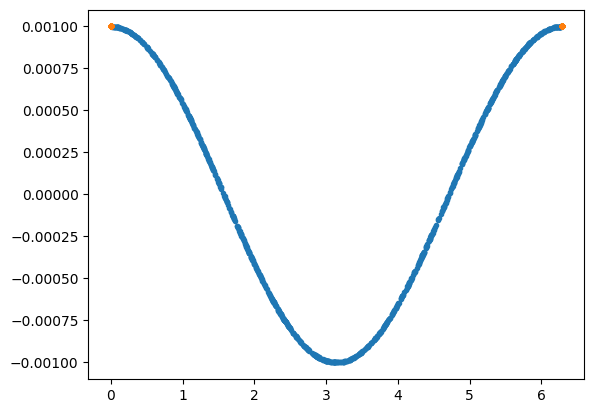

In [39]:
phi_init = solution[1]*np.cos(0.*(tx_init[:, 1:2]-0*tx_init[:, 0:1]))
phi_boundary = solution[1]*np.cos(0.*(tx_boundary[:, 1:2]-0*tx_boundary[:, 0:1]))
u_exact = solution[1]*np.cos(0.*(tx_init[:, 1:2])-0*tx_eqn[:, 0:1])
ii = 0
for aii in solution[2:]:
    ii = ii+1.
    phi_init = phi_init + aii*np.cos(ii*(tx_init[:, 1:2]-0*tx_init[:, 0:1]))
    phi_boundary = phi_boundary + aii*np.cos(ii*(tx_boundary[:, 1:2]-0*tx_boundary[:, 0:1]))
    u_exact = u_exact + aii*np.cos(ii*(tx_eqn[:, 1:2]-0*tx_eqn[:, 0:1])) 
plt.plot(tx_eqn[:,1:2],u_exact,'.')
plt.plot(tx_boundary[:,1:2],phi_boundary,'.')
plt.show()

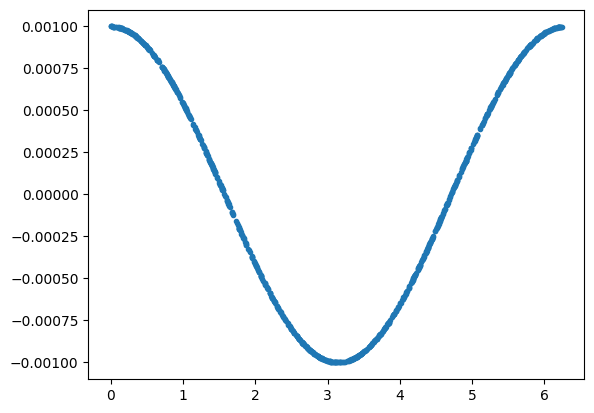

In [48]:
plt.plot(tx_eqn[:,1:2], u_exact,'.')